# Calibration

## 0. Import packages

In [1]:
%matplotlib notebook

import cv2
import matplotlib.pyplot

import openalea.phenomenal.data as phm_data
import openalea.phenomenal.display as phm_display
import openalea.phenomenal.calibration as phm_calib

## 1. Detect chessboard corners in the images

### 1.0 Load Images

<IPython.core.display.Javascript object>


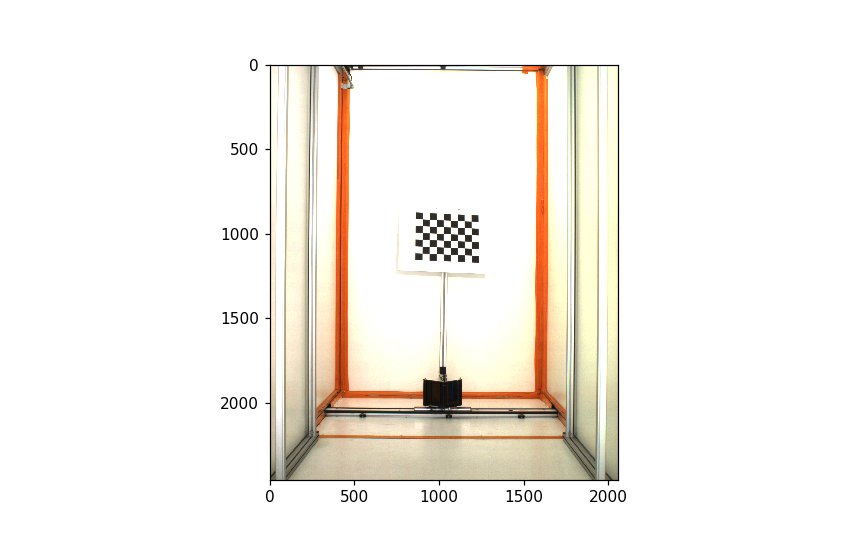

In [2]:
plant_number = 1
chessboard_images = phm_data.chessboard_images(plant_number=plant_number)[0]
phm_display.show_image(chessboard_images['side'][42])

### 1.1 Create chessboard object

Create chessboard object with square size and shape of chessboard

In [3]:
square_size_of_chessboard = 47 # In mm
square_shape_of_chessboard = (8, 6) # (8 square x 6 square on chessboard)

# BUILD CHESSBOARD OBJECT
chessboard = phm_calib.Chessboard(square_size_of_chessboard, 
                                  square_shape_of_chessboard)

# DISPLAY IT
print(chessboard)

Chessboard Attributes :
Square size (mm): 47
Shape : (8, 6)



### 1.2 Detect corners from images

In [4]:
for id_camera in chessboard_images:
    for angle in chessboard_images[id_camera]:
        im = chessboard_images[id_camera][angle]
        found = chessboard.detect_corners(id_camera, angle, im)
        print("Angle {} - Chessboard corners {}".format(angle, "found" if found else "not found"))

Angle 42 - Chessboard corners found


### 1.3 Display chessboard corners on images

<IPython.core.display.Javascript object>


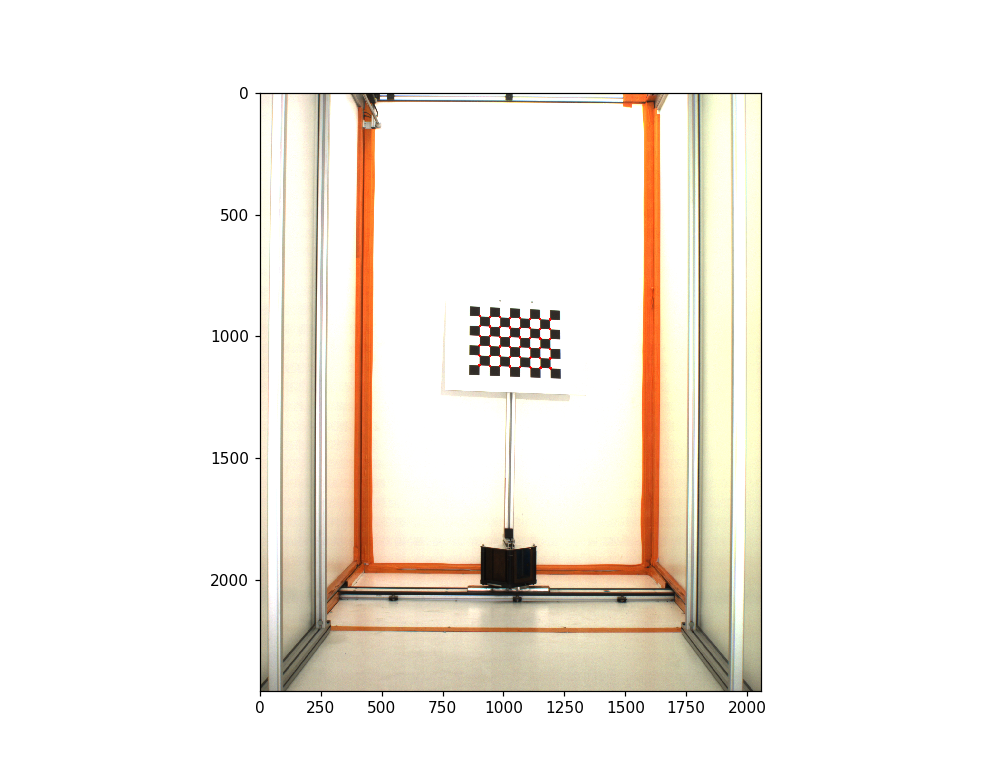

In [5]:
angle = 42
img = chessboard_images["side"][angle].copy()

# DRAW RED POINT ON IMAGE CORNERS POSITION
points_2d = chessboard.image_points[id_camera][angle].astype(int)
for x, y in zip(points_2d[:, 0, 1], points_2d[:, 0, 0]):
    cv2.circle(img, (y, x), 5, (255, 0, 0), -1)

phm_display.show_image(img)

### 2.4 Dump & load

In [6]:
chessboard.dump('chessboard.json')

In [7]:
chessboard = phm_calib.Chessboard.load('chessboard.json')

## 2. Multi-camera calibration

### 2.0 Load chessboard object with all corners points

In [8]:
# Load chessboard object
chessboards = phm_data.chessboards(plant_number=plant_number)

chessboards_image_points_side_42 = chessboards[0].image_points[id_camera][42].copy()

# Remove some angle to optimize time processing, keep only the 30 modulo image
id_camera = "side"
for angle in range(0, 360, 3):
    if not (angle % 30 == 0):
        chessboards[0].image_points[id_camera].pop(angle, None)
        chessboards[1].image_points[id_camera].pop(angle, None)

# Used angle :
print(list(chessboards[0].image_points[id_camera].keys()) + 
      list(chessboards[1].image_points[id_camera].keys()))

[0.0, 30.0, 60.0, 90.0, 180.0, 210.0, 240.0, 270.0]


### 2.1 Do calibration

In [9]:
# Define size image of image chessboard to calibrate
size_image = (2056, 2454)

# Calibrate
id_camera = "side"
calibration = phm_calib.CalibrationCameraSideWith2TargetYXZ()
err = calibration.calibrate(chessboards[0].get_corners_2d(id_camera), 
                            chessboards[0].get_corners_local_3d(),
                            chessboards[1].get_corners_2d(id_camera), 
                            chessboards[1].get_corners_local_3d(),
                            size_image,
                            number_of_repetition=0, # repetion here is 0 to optimize time consuming (for better result put 4)
                            verbose=False)

# Error of reprojection (in pixel distance) for all point in the target (48)
# So real error is err / 48
print(err)

6.15285639282695


### 2.2 Dump & load

In [10]:
# Dump
calibration.dump('calibration_camera_side.json')

In [11]:
# Load
calibration = phm_calib.CalibrationCameraSideWith2Target.load('calibration_camera_side.json')

### 2.6 Viewing calibration result

#### 2.6.2 Show chessboard image with corners projection

<IPython.core.display.Javascript object>


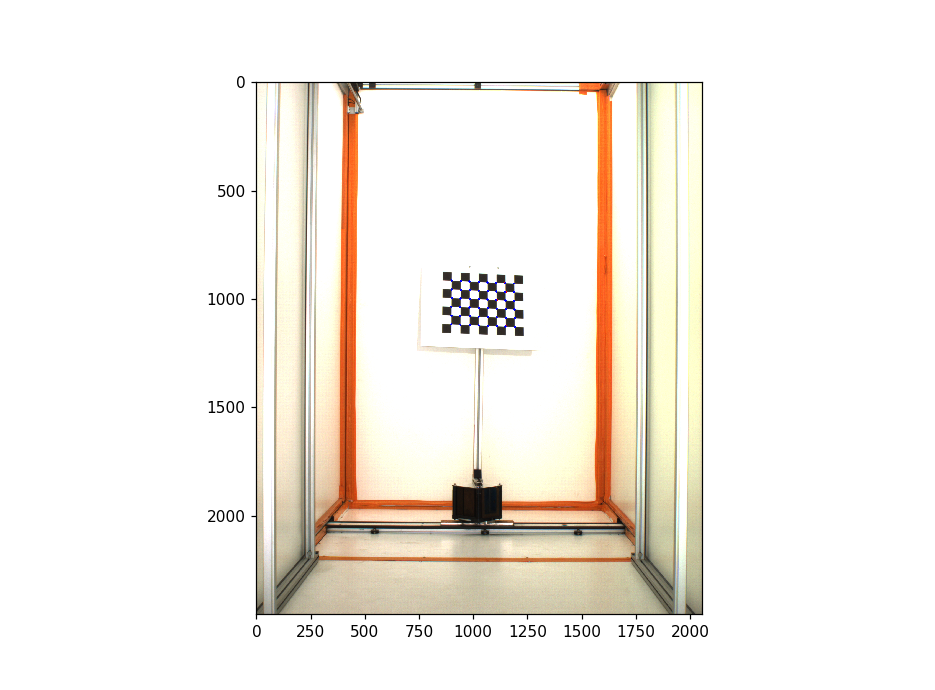

In [12]:
angle = 42
circle_radius = 5
img = chessboard_images['side'][angle].copy()

# RED POINTS ARE POINTS POSITIONS DETECTED BY OPENCV CHESSBOARD DETECTION 
pt_2d = chessboards_image_points_side_42.astype(int)
for x, y in zip(pt_2d[:, 0, 1], pt_2d[:, 0, 0]):
    cv2.circle(img, (y, x), circle_radius, (255, 0, 0), -1)

# BLUE POINTS ARE POINTS POSITIONS PROJECTED BY CALIBRATION CHESSBOARD COMPUTATION
points_2d = calibration.get_target_1_projected(42, chessboards[0].get_corners_local_3d())
for x, y in map(lambda x : map(int, tuple(x)), points_2d):
    cv2.circle(img, (x, y), circle_radius, (0, 0, 255), -1)

phm_display.show_image(img)